In [42]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import vanet_tools as vp
from scipy.spatial import distance
from collections import defaultdict
import xml.etree.ElementTree as ET

In [43]:
pasubio_sumo = pd.read_csv('pasubio.csv',delimiter=';').dropna()

In [11]:
len(set(pasubio_sumo['vehicle_id']))

8776

In [12]:
pasubio_sumo['timestep_time'].max()

4604.0

In [14]:
coordinates = pasubio_sumo[['vehicle_x','vehicle_y']]

In [58]:
MICROCLOUD_RANGE= 150
NUM_MICROCLOUDS = 10

In [59]:
microcloud_coords =vp.create_coords(coordinates,MICROCLOUD_RANGE,NUM_MICROCLOUDS)
# microcloud_coords = [[310,1200],[350,420],[920,250],[780,1000],[1400,770]]

In [ ]:
# tree = ET.parse('Bologna_small-0.29.0/pasubio/pasubio_buslanes.net.xml')
# root = tree.getroot()

In [54]:
# microcloud_coords = []
# for neighbor in root.iter('junction'):
#     attrib = neighbor.attrib
#     if attrib.get('type')=="priority":
#         x,y = neighbor.attrib.get('x'),neighbor.attrib.get('y')
#         micro_cloud  = [int(float(x)),int(float(y))]
#         microcloud_coords.append(micro_cloud)
# microcloud_coords = microcloud_coords[:NUM_MICROCLOUDS]
# print(microcloud_coords)

In [44]:
microcloud_coords = pd.read_csv('Pasubio_config.csv',index_col=0).values

In [46]:
coordinates_values = coordinates.values

In [ ]:
num_physical_pasubio = 10
kmeans = KMeans(n_clusters=num_physical_pasubio).fit(coordinates_values)
y_kmeans = kmeans.predict(coordinates_values)

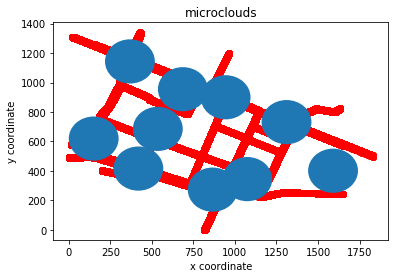

In [39]:
coords_x,coords_y = pasubio_sumo['vehicle_x'],pasubio_sumo['vehicle_y']
vp.plot_microclouds(centers,MICROCLOUD_RANGE,coords_x,coords_y)

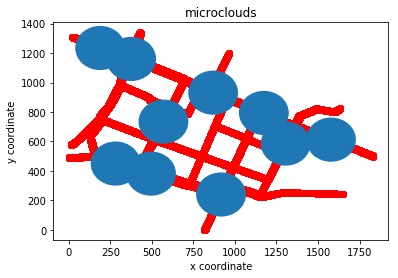

In [60]:
vp.plot_microclouds(microcloud_coords,MICROCLOUD_RANGE,coords_x,coords_y)

In [ ]:
vp.store_microcloud_config(microcloud_coords,"Pasubio_config.csv")

In [61]:
time_col = pasubio_sumo['timestep_time']
start,end = int(time_col.min()), int(time_col.max())

In [62]:
time_steps= pasubio_sumo.groupby('timestep_time')

Paremeters that must be established, mininum amount of trafic for microcloud, relation of power to number of cars

In [63]:
def determine_closest(micro_clouds,x,y):
    min_distance = float('inf')
    index_of_closest = -1
    for index,micro_cloud in enumerate(micro_clouds):
        x_coord,y_coord =  micro_cloud
        current_distance = distance.euclidean((x,y),(x_coord,y_coord))
        if current_distance<min_distance:
            min_distance = current_distance
            index_of_closest = index
    return index_of_closest
            

In [65]:
cloud_to_power = defaultdict(list)
for time in range(start,end+1):
    time_step = time_steps.get_group(time)
    current_power = [0 for _ in range(len(microcloud_coords))]
    for index, row in time_step.iterrows():
        x,y = row['vehicle_x'],row['vehicle_y']
        index_of_closest =determine_closest(microcloud_coords,x,y)
        closest = microcloud_coords[index_of_closest]
        if distance.euclidean((closest[0],closest[1]),(x,y))<MICROCLOUD_RANGE:
            current_power[index_of_closest]+=1
    for index,power in enumerate(current_power):
        cloud_to_power[index].append(power)
            

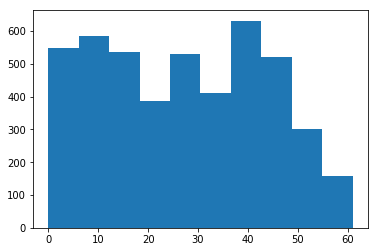

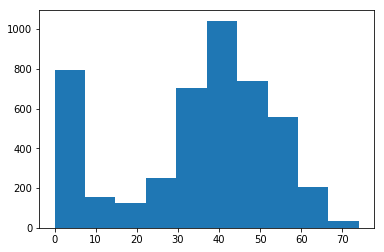

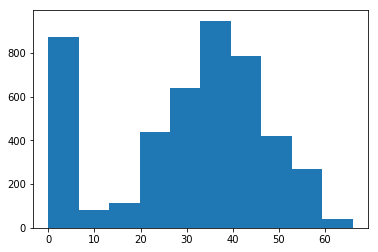

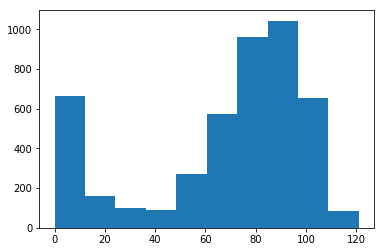

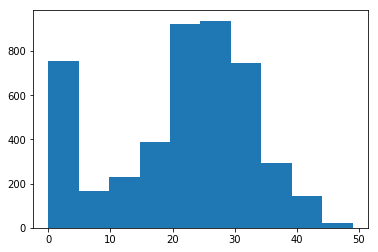

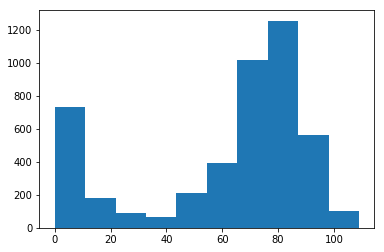

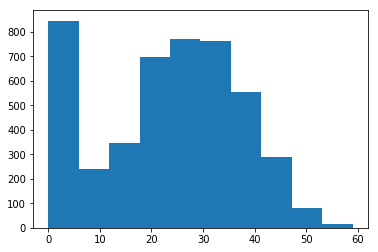

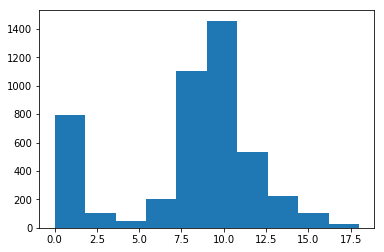

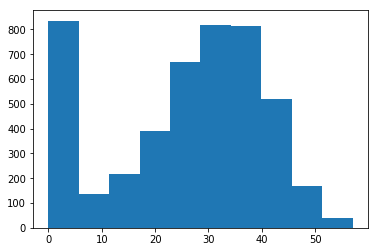

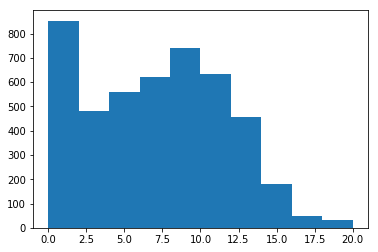

In [72]:
for i in range(len(microcloud_coords)):
    plt.hist(cloud_to_power[i])
    plt.show()

In [74]:
def avg(nums):
    return sum(nums)/len(nums)

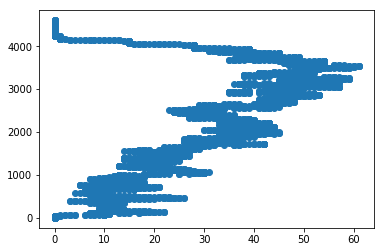

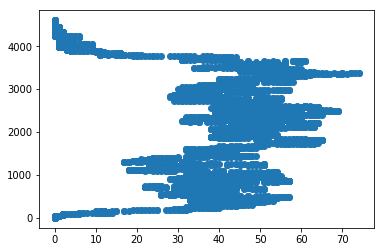

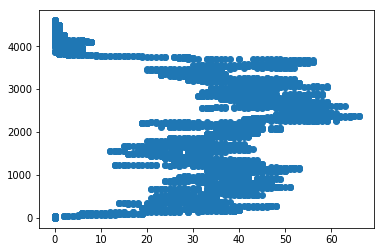

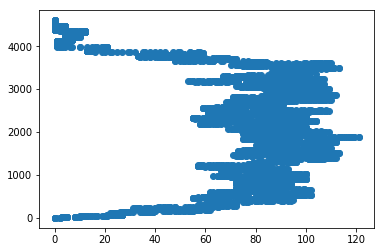

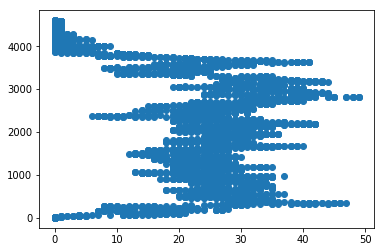

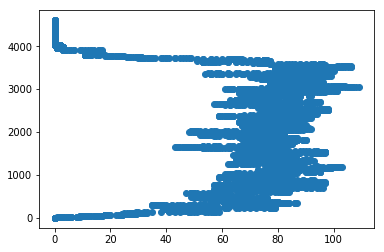

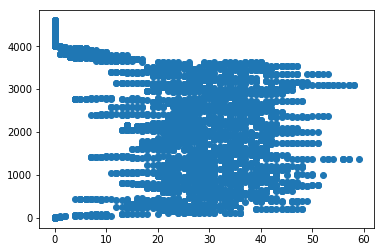

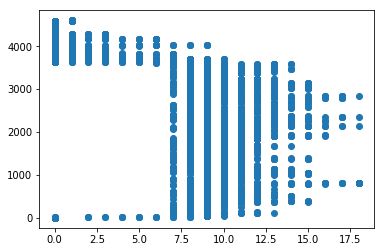

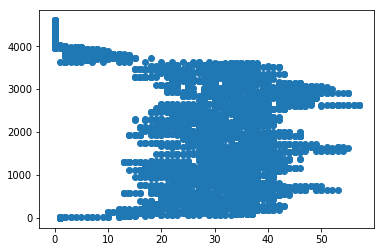

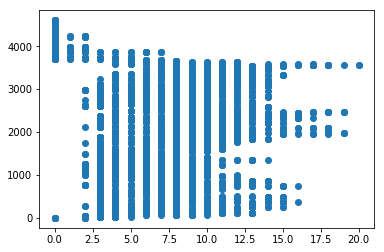

In [91]:
times = [time for time in range(len(cloud_to_power[0]))]
for i in range(len(microcloud_coords)):
    cloud_power = cloud_to_power[i]
    plt.scatter(cloud_power,times)
    plt.show()

In [97]:
def find__reliability(least_cars_needed, cloud_power):
    reliable_time = 0
    for power in cloud_power:
        if (power>=least_cars_needed):
            reliable_time+=1
    return reliable_time/len(cloud_power)

In [94]:
LEAST_CARS_NEEDED = 3

In [98]:
for i in range(len(microcloud_coords)):
    coord = microcloud_coords[i]
    average = avg(cloud_to_power[i])
    reliability = find__reliability(LEAST_CARS_NEEDED,cloud_to_power[i])
    print(coord, average,reliability)

[569.99 734.37] 26.963952225841478 0.8894679695982628
[868.9  931.24] 34.48165038002171 0.8723127035830619
[1174.34  793.67] 30.200651465798046 0.8623235613463627
[ 375.88 1160.31] 67.67709011943539 0.9450597176981542
[1305.51  585.69] 21.417806731813247 0.8555917480998915
[916.64 239.78] 60.75222584147666 0.8588490770901195
[495.14 381.66] 23.10944625407166 0.8488599348534202
[1578.18  612.23] 7.763083604777416 0.8180238870792617
[282.07 449.84] 25.518349619978284 0.8505971769815418
[ 189.04 1234.44] 6.599782844733985 0.7897937024972855


In [99]:
cloud_df = pd.DataFrame(cloud_to_power)

In [108]:
cloud_df.to_csv("virtual_servers_config.csv",index_label=False)